---
title: "人工智能 - 基于 TenserFlow 的线性回归与逻辑回归"
date: 2025-05-05T21:40:32+08:00
author: "Liu Zheng"
tags: ["笔记", "实验"]
categories: "实验笔记"
---

## 基于 TensorFlow 的线性回归与逻辑回归

### 加载组件

In [1]:
import tensorflow
import numpy
import matplotlib.pyplot
import pandas

matplotlib.pyplot.style.use("../matplotlib.mplstyle")

### 加载数据

In [2]:
# 读取数据集方法，具备分块和流处理能力
#
# def decode(row):
#     template = [
#         tensorflow.constant(0.0, dtype=tensorflow.float32),
#         tensorflow.constant(0.0, dtype=tensorflow.float32),
#         tensorflow.constant(0.0, dtype=tensorflow.float32),
#     ]
#     size, rooms, price = tensorflow.io.decode_csv(row, template)
#     size = size / 1000.0
#     price = price / 1000.0
#     return size, rooms, price
# 
# DATASET = tensorflow.data.TextLineDataset("./202501061035.csv").skip(1).map(decode).batch(32)

DATASET = pandas.read_csv("./202501061035.csv")

X = (DATASET[["size", "rooms"]]).astype(float).to_numpy()
Y = (DATASET["price"]).astype(float).to_numpy()

X[:, 0] = X[:, 0] / 1000
Y = Y / 1000

# 转 TenserFlow 张量
X = tensorflow.convert_to_tensor(X, dtype=tensorflow.float32)
Y = tensorflow.convert_to_tensor(Y, dtype=tensorflow.float32)

### 构建一元线性回归

In [3]:
# 构建线形层
LINEAR_LAYER = tensorflow.keras.layers.Dense(units=1, activation="linear")
# 模型构建
MODEL = tensorflow.keras.Sequential([LINEAR_LAYER])
# 损失（代价）函数定义，均方误差（Mean Squared Error, MSE）
LOSS = tensorflow.keras.losses.MeanSquaredError()
# 梯度下降定义，随机梯度下降 (SGD)
OPTIMIZER = tensorflow.keras.optimizers.SGD(learning_rate=0.002)
# 编译模型
# HISTORY = MODEL.compile(optimizer=OPTIMIZER, loss=LOSS)
MODEL.compile(optimizer=OPTIMIZER, loss=LOSS)
# 使用 FIT 方法训练模型
# HISTORY = MODEL.fit(X, Y, epochs=200, verbose=0)
# 使用 自定义方法训练模型
HISTORY = []
EPOCHS = 200  # 训练轮次
for epoch in range(EPOCHS):
    with tensorflow.GradientTape() as tape:
        loss = LOSS(Y, MODEL(X[:, 0][..., tensorflow.newaxis]))  # 前向传播 -> 计算损失
    gradients = tape.gradient(loss, MODEL.trainable_variables)  # 计算梯度
    OPTIMIZER.apply_gradients(zip(gradients, MODEL.trainable_variables))  # 更新权重和偏置
    if (epoch + 1) % 10 == 0:
        fw, fb = LINEAR_LAYER.get_weights()
        HISTORY.append([fw[0][0], fb[0], loss.numpy()])
        print(f"Cost is {loss:.4e}, Weights is {fw[0][0]:.4e}, Bias is {fb[0]:.4e}")
        
FW, FB = LINEAR_LAYER.get_weights()
print(f"Weights is {FW[0][0]:.4e}, Bias is {FB[0]:.4e}")

Cost is 9.0132e+04, Weights is 2.6956e+01, Bias is 1.2412e+01
Cost is 5.9207e+04, Weights is 4.9246e+01, Bias is 2.2353e+01
Cost is 3.9402e+04, Weights is 6.7081e+01, Bias is 3.0317e+01
Cost is 2.6718e+04, Weights is 8.1350e+01, Bias is 3.6698e+01
Cost is 1.8595e+04, Weights is 9.2765e+01, Bias is 4.1813e+01
Cost is 1.3393e+04, Weights is 1.0190e+02, Bias is 4.5914e+01
Cost is 1.0061e+04, Weights is 1.0920e+02, Bias is 4.9204e+01
Cost is 7.9274e+03, Weights is 1.1504e+02, Bias is 5.1845e+01
Cost is 6.5609e+03, Weights is 1.1972e+02, Bias is 5.3966e+01
Cost is 5.6856e+03, Weights is 1.2345e+02, Bias is 5.5671e+01
Cost is 5.1251e+03, Weights is 1.2644e+02, Bias is 5.7044e+01
Cost is 4.7661e+03, Weights is 1.2882e+02, Bias is 5.8150e+01
Cost is 4.5361e+03, Weights is 1.3073e+02, Bias is 5.9043e+01
Cost is 4.3888e+03, Weights is 1.3225e+02, Bias is 5.9766e+01
Cost is 4.2944e+03, Weights is 1.3346e+02, Bias is 6.0352e+01
Cost is 4.2340e+03, Weights is 1.3443e+02, Bias is 6.0828e+01
Cost is 

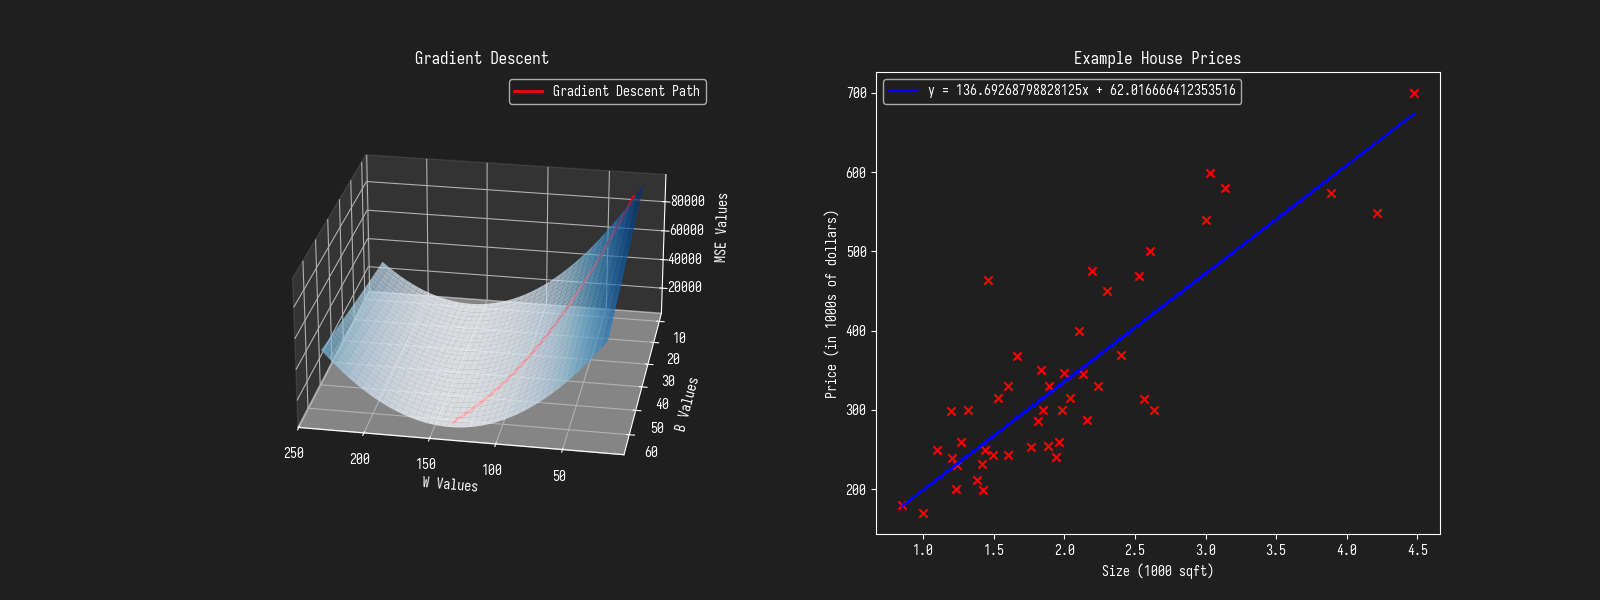

In [4]:
%config InlineBackend.print_figure_kwargs = {"bbox_inches": None}

HISTORY = tensorflow.constant(HISTORY)

W = tensorflow.range(20, 240, 5, dtype=tensorflow.float32)
B = tensorflow.range(10, 65, 1, dtype=tensorflow.float32)
W, B = tensorflow.meshgrid(W, B)

MSE = tensorflow.keras.losses.MeanSquaredError(reduction=tensorflow.keras.losses.Reduction.NONE)

def compute_cost(args):
    predictions = args[0][..., tensorflow.newaxis] * X[:, 0] + args[1][..., tensorflow.newaxis]
    return MSE(Y, predictions)

Z = tensorflow.vectorized_map(compute_cost, (W, B))

figure = matplotlib.pyplot.figure(figsize=(16, 6))
axes1 = figure.add_subplot(1, 2, 1, projection="3d")
surface = axes1.plot_surface(W, B, Z, cmap=matplotlib.cm.Blues, alpha=0.75)

axes1.view_init(elev=25, azim=100, roll=0)
axes1.set_title("Gradient Descent")
axes1.set_xlabel("W Values")
axes1.set_ylabel("B Values")
axes1.set_zlabel("MSE Values", labelpad=10)

tws, tbs, mse = HISTORY[:, 0], HISTORY[:, 1], HISTORY[:, 2]
axes1.plot3D(tws, tbs, mse, color="red", linewidth=2, label="Gradient Descent Path")
axes1.legend()
axes1.set_box_aspect([2, 2, 1])

axes2 = figure.add_subplot(1, 2, 2)

axes2.scatter(X[:, 0], Y, marker="x", c="r")
axes2.plot(X[:, 0], FW[0][0] * X[:, 0] + FB[0], color="blue", label=f"y = {FW[0][0]}x + {FB[0]}")
axes2.set_title("Example House Prices")
axes2.set_xlabel("Size (1000 sqft)")
axes2.set_ylabel("Price (in 1000s of dollars)")
axes2.legend()

matplotlib.pyplot.show()

### 构建逻辑回归

In [5]:
DATASET = pandas.read_csv("./202503081558.csv")

X = (DATASET[["C1", "C2"]]).astype(float).to_numpy()
Y = (DATASET["LABEL"]).astype(float).to_numpy()

X = X / 100

# 转 TenserFlow 张量
X = tensorflow.convert_to_tensor(X, dtype=tensorflow.float32)
Y = tensorflow.convert_to_tensor(Y, dtype=tensorflow.float32)

In [6]:
# 构建逻辑层
LOGISTIC_LAYER = tensorflow.keras.layers.Dense(units=1, activation="sigmoid")
# 模型构建
MODEL = tensorflow.keras.Sequential([LOGISTIC_LAYER])
# 损失（代价）函数定义，二元交叉熵（Binary Crossentropy）
LOSS = tensorflow.keras.losses.BinaryCrossentropy()
# 梯度下降定义，自适应矩估计 (ADAM, Adaptive Moment Estimation)
OPTIMIZER = tensorflow.keras.optimizers.Adam(learning_rate=0.8)
# 编译模型
# HISTORY = MODEL.compile(optimizer=OPTIMIZER, loss=LOSS)
MODEL.compile(optimizer=OPTIMIZER, loss=LOSS)
# 使用 FIT 方法训练模型
HISTORY = MODEL.fit(X, Y, epochs=200, verbose=0)

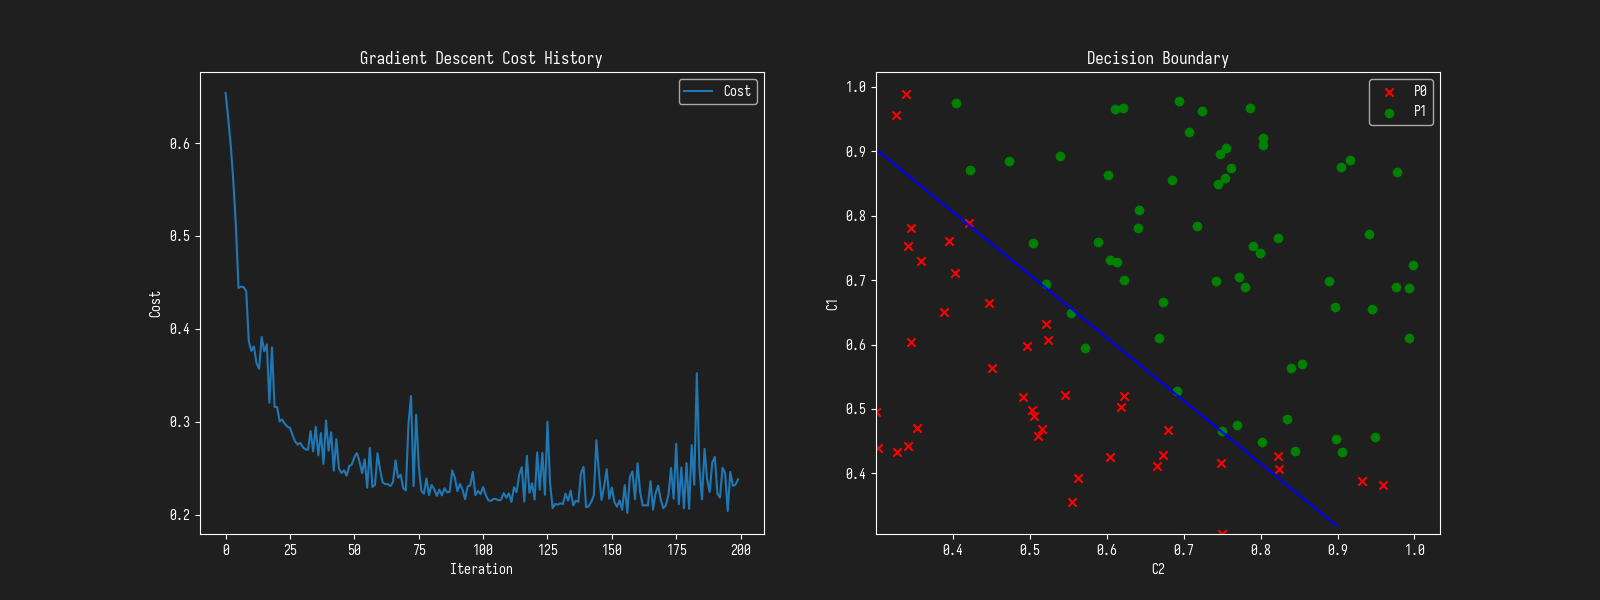

In [7]:
figure = matplotlib.pyplot.figure(figsize=(16, 6))
axes1 = figure.add_subplot(1, 2, 1)
axes1.plot(HISTORY.history["loss"], label="Cost")
axes1.set_title("Gradient Descent Cost History")
axes1.set_ylabel("Cost")
axes1.set_xlabel("Iteration")
axes1.legend()

XMIN, XMAX = tensorflow.reduce_min(X, axis=0), tensorflow.reduce_max(X, axis=0)
XMIN1, XMAX1 = XMIN[0], XMAX[0]
XMIN2, XMAX2 = XMIN[1], XMAX[1]
XX1, XX2 = tensorflow.meshgrid(tensorflow.range(XMIN1, XMAX1, 0.1), tensorflow.range(XMIN2, XMAX2, 0.1))
GRID = tensorflow.stack([XX1, XX2], axis=-1)
PROBS = LOGISTIC_LAYER(GRID)

SR1 = tensorflow.gather_nd(X, tensorflow.where(tensorflow.equal(Y, 0)))
SR2 = tensorflow.gather_nd(X, tensorflow.where(tensorflow.equal(Y, 1)))

axes2 = figure.add_subplot(1, 2, 2)
axes2.scatter(SR1[:, 0], SR1[:, 1], marker="x", c="r", label="P0")
axes2.scatter(SR2[:, 0], SR2[:, 1], marker="o", c="g", label="P1")
axes2.contour(XX1, XX2, tensorflow.squeeze(PROBS), levels=[0.5], colors="b")
axes2.set_title("Decision Boundary")
axes2.set_ylabel("C1")
axes2.set_xlabel("C2")
axes2.legend()

matplotlib.pyplot.show()

In [8]:
features = [50.534788289883 / 100, 48.85581152764205 / 100]
label = MODEL.predict(tensorflow.convert_to_tensor([features], dtype=tensorflow.float32))

print(f"Logistic for {features[0]} C1 and {features[1]} C2 is Label: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Logistic for 0.5053478828988299 C1 and 0.48855811527642046 C2 is Label: [[0.01866285]]
